In [1]:
import os
import random
import cv2
import numpy as np
import seaborn as sns
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.applications import VGG16, Xception, InceptionV3, ResNet50, InceptionResNetV2
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.utils import to_categorical
from concurrent.futures import ProcessPoolExecutor
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from glob import glob

Using TensorFlow backend.


## Configuration

In [2]:
CORE = 4  # cpu core

# datasets directory
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

# image shape
ROWS = 225
COLS = 225
CHANNELS = 3

## Preparing image

In [3]:
def resize_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    with ProcessPoolExecutor(max_workers=CORE) as executor:
        data[:] = list(executor.map(resize_img, images))
    
    return data


x_train = prep_data(glob('data/train/*/*'))
x_valid = prep_data(glob('data/validation/*/*'))

## Preparing labels

In [4]:
# label in string
y_train_string = [i.split('/')[2] for i in glob('data/train/*/*')]
y_valid_string = [i.split('/')[2] for i in glob('data/validation/*/*')]

lb = LabelBinarizer()
lb.fit(y_train_string)

# label in binary
y_train = lb.transform(y_train_string)
y_valid = lb.transform(y_valid_string)

## Visualize random data

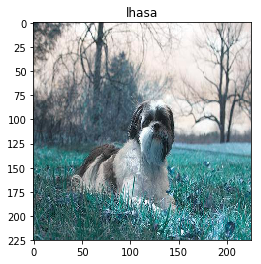

In [5]:
idx = random.randint(0, len(x_train))
plt.imshow(x_train[idx])
plt.title(y_train_string[idx])
plt.show()

## Simple Neural Network

In [6]:
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

## VGG16

In [7]:
vgg = VGG16(weights='imagenet', include_top=False)
x_train_feature = vgg.predict(x_train, verbose=1)
x_valid_feature = vgg.predict(x_valid, verbose=1)

2037/2037 [==============================] - 24s 12ms/step


In [18]:
model = Sequential()
model.add(Flatten(input_shape=x_train_feature.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))
model.compile(
    optimizer='rmsprop', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

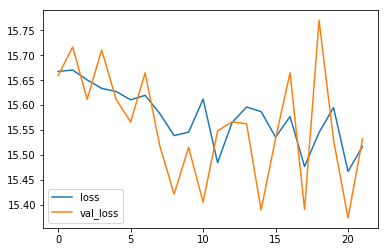

In [ ]:
model.fit(x_train_feature, y_train,
      epochs=100,
      batch_size=32,
      validation_data=(x_valid_feature, y_valid),
      callbacks=[plot_losses],
      verbose=0)